<a href="https://colab.research.google.com/github/deepakri201/NLSTNatureSciData/blob/main/TechnicalValidation/validateNLSTSegVolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical validation of volume

In this notebook, we compare the volume from pyradiomics SRs to the volumes reported from the Excel spreadsheets from the NLSTSeg authors.

Deepa Krishnaswamy\
Brigham and Women's Hospital\
Dec 2025

# Install pyradiomics

In [1]:
!pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git

  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-284meugo
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-284meugo
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 263.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 158.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 379.4 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=f951204d034471463cd5083b443b8c7e0d7ad21b70104cd66e87440f37f42d4c
  Stored in directory

# Parameterization

In [2]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [3]:
!pip install zenodo-get

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.9/252.9 kB 8.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4a6c8f99cf360c9fbf6422f3dc586feaad6e225e69cb7d507f6e4a0c841a4275
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [4]:
import os
import sys
import time

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.cloud import storage


# Get Excel spreadsheets from NLSTSeg

In [5]:
# Get the Excel spreadsheets from NLSTSeg Zenodo page
!wget https://zenodo.org/records/14838349/files/1_Table.zip
!unzip "/content/1_Table.zip"

# Set filenames
nlstseg_image_filename = "/content/1_Table/Image.xlsx"
nlstseg_patient_filename = "/content/1_Table/Patient.xlsx"
nlstseg_label_filename = "/content/1_Table/Label.xlsx"

# Read the tables into a dataframe
df_image = pd.read_excel(nlstseg_image_filename)
df_patient = pd.read_excel(nlstseg_patient_filename)
df_label = pd.read_excel(nlstseg_label_filename)

--2025-12-12 21:30:33--  https://zenodo.org/records/14838349/files/1_Table.zip
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170056 (166K) [application/octet-stream]
Saving to: ‘1_Table.zip’

1_Table.zip         100%[===================>] 166.07K   361KB/s    in 0.5s    

2025-12-12 21:30:34 (361 KB/s) - ‘1_Table.zip’ saved [170056/170056]

Archive:  /content/1_Table.zip
   creating: 1_Table/
  inflating: 1_Table/Image.xlsx      
  inflating: 1_Table/Label.xlsx      
  inflating: 1_Table/Patient.xlsx    


In [6]:
# Print out some stats from the dataframes

print(len(list(set(df_image['ID'].values))))
print(len(list(set(df_image['StudyInstanceUID'].values))))
print(len(list(set(df_image['SeriesInstanceUID'].values))))

605
602
602


# Compare volumes using BQ table

## Get the measurements from BQ

In [7]:
client_bq = bigquery.Client(project=project_name)

query = f"""
          WITH series_list AS (
            SELECT DISTINCT
              SeriesInstanceUID
            FROM
              `bigquery-public-data.idc_v23.dicom_all`
            WHERE
              analysis_result_id = 'NLSTSeg' AND
              Modality = 'SEG'
          )

          SELECT
            quant_meas.PatientID,
            quant_meas.sourceSegmentedSeriesUID,
            quant_meas.segmentationSegmentNumber,
            quant_meas.findingSite.CodeMeaning,
            quant_meas.Value
          FROM
            `bigquery-public-data.idc_v23.quantitative_measurements` AS quant_meas
          JOIN
            series_list
          ON
            series_list.SeriesInstanceUID = quant_meas.segmentationSeriesUID
          WHERE
             Quantity.CodeMeaning = 'Volume from Voxel Summation'
          ORDER BY
            PatientID,
            sourceSegmentedSeriesUID,
            segmentationSegmentNumber
"""

df_meas = client_bq.query(query).to_dataframe()

In [8]:
# Print out some stats to confirm

print(len(list(set(df_meas['PatientID'].values))))
print(len(list(set(df_meas['sourceSegmentedSeriesUID'].values))))

600
600


## Now join with the NLSTSeg original excel spreadsheets

These numbers make sense. There were some problematic IDs from the original NLSTSeg, therefore reducing the patients from 605 to 600.

In [9]:
df_label['ID'] = [str(f) for f in df_label['ID'].values]
df_join = pd.merge(df_label, df_meas, how='inner', left_on=['ID', 'Mark_labels'], right_on=['PatientID', 'segmentationSegmentNumber'])
df_join['Value_mod'] = [np.float32(f)/1000.00 for f in df_join['Value'].values]

print(len(df_join))
print(len(list(set(df_join['PatientID'].values))))

704
600


## Now plot and compare the volumes

avg_diff: 1.2023465242199666e-05
min_diff: -0.0050000262260436745
max_diff: 0.004996007084846488
std_diff: 0.0028791392046965967


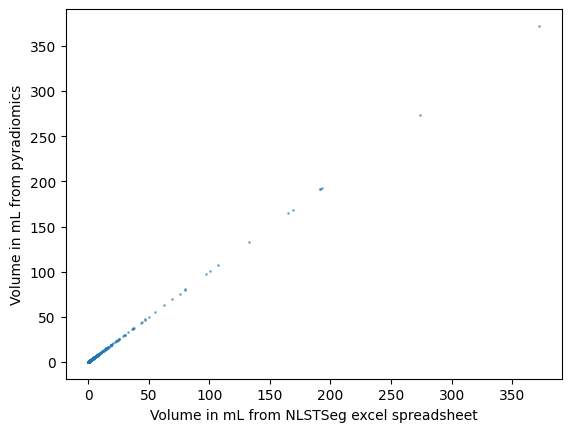

In [10]:
# Now plot

nlstseg_values = df_join['Tumor_V(cm3)'].values
pyradiomics_values = df_join['Value_mod'].values

diff_values = nlstseg_values - pyradiomics_values
df_join['volume_diff'] = df_join['Tumor_V(cm3)'].values - df_join['Value_mod'].values

avg_diff = np.mean(diff_values)
min_diff = np.min(diff_values)
max_diff = np.max(diff_values)
std_diff = np.std(diff_values)
print('avg_diff: ' + str(avg_diff))
print('min_diff: ' + str(min_diff))
print('max_diff: ' + str(max_diff))
print('std_diff: ' + str(std_diff))

plt.figure()
plt.scatter(nlstseg_values, pyradiomics_values, s=1, alpha=0.5)
plt.xlabel('Volume in mL from NLSTSeg excel spreadsheet')
plt.ylabel('Volume in mL from pyradiomics')
plt.show()

In [11]:
# Print out the correlation coefficient

print(np.corrcoef(nlstseg_values,pyradiomics_values)[0,1])

0.9999999937240799
